In [1]:
import sys
import os


SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)

from simon_device import *
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import MinMaxScaler, Normalizer



sns.set(font_scale=2, rc={'lines.linewidth':5})
sns.set_style('white')

data_dir = '/home/chery/Desktop/ACTR-Simon-Re/data'

ACT-R connection has been started.


## EVC in Realistic Task


In [2]:
def run_evc_simulation(motivation=[1,2,3], init_cost=[0.05, 0.1, 0.5], log=False, load=False, n_simulation=1):
    if load:
        df_model, _ = load_simulation(log=log)
        return df_model
    
    param_comb = [(motivation[i], init_cost[i]) for i in range(len(init_cost))]
    param_sets = [{"motivation": motivation, "init_cost": init_cost, 'update_cost':False, 'valid_cue_percentage':0.8} for motivation, init_cost in param_comb]

    df_models = []
    for param_set in param_sets: 
        df_model, _ = run_simulation(log=log, load=False, verbose=False, n_simulation=n_simulation, n_session=1, param_set=param_set)
        df_models.append(df_model)

    df = pd.concat(df_models, axis=0)
    return df

In [3]:
def get_category(df, col_name, level_dict):
    df[col_name+'_level'] = np.nan
    for level, value_range in level_dict.items():
        df.loc[(df[col_name]>=value_range[0]) & (df[col_name]<=value_range[1]), col_name+'_level'] = level
    return df

def process_model_data(df):
    df_model = df.copy()  
    df_model = get_category(df_model, 'motivation', motivation_level) 
    df_model = get_category(df_model, 'cost', cost_level) 
    
    df_model['u_diff'] = df_model['u_check'] - df_model['u_dont_check']
    df_model['motivation_cost_level'] = df_model[['motivation_level', 'cost_level']].apply(tuple, axis=1).map({('low', 'low'):'low', ('medium', 'medium'):'medium', ('high', 'high'):'high'})
    df_model['motivation_cost_level'] = pd.Categorical(df_model['motivation_cost_level'], categories=['low', 'medium', 'high'])
    df_model[['u_check_norm', 'check_time_norm', 'received_reward_norm', 'motivation_norm', 'cost_norm']] =  MinMaxScaler().fit_transform(df_model[['u_check', 'check_time', 'received_reward', 'motivation', 'cost']])
    return df_model

def plot_evc(df_model):    
    fig, ax = plt.subplots(figsize=(15, 6))
    fig.suptitle('The Expected Value of Control in the Realistic ACT-R Model')
    ax = sns.lineplot(data=df_model, x='motivation_cost_level', y='cost_norm',  markers=True, marker='o', markersize=20, errorbar='se', label='AT (Cost)', color='tomato')
    ax = sns.lineplot(data=df_model, x='motivation_cost_level', y='motivation_norm',  markers=True, marker='o', markersize=20, errorbar='se',  label='M (Payoff)', color='forestgreen')
    ax = sns.lineplot(data=df_model, x='motivation_cost_level', y='u_check_norm', markers=True, marker='o', markersize=20, errorbar='se',  label='Utility of "check" (EVC)', color='mediumpurple')

    # ax = sns.barplot(data=df_model, x='control_intensity', y='check_time', color='gray', alpha=0.2)
    ax.legend(loc='best')
    ax.set_ylabel('')
    ax.set_xlabel('(M, Cost) Pairs')
    plt.show()

In [4]:
# df = run_evc_simulation(motivation=motivation, init_cost=init_cost, log='evc_s100_', load=True, n_simulation=100)
df = pd.read_csv('../data/evc_s100_230627/model_output.csv')

In [5]:
# simple 
motivation = [1, 1.5, 3]
init_cost = [0.01, 0.1, 0.5]

# more fine-grained parameters (evc_s100_0627)
motivation_level = {'low': (0.1, 1), 'medium': (1.1, 2), 'high': (2.1, 4)}
cost_level = {'low': (0.01, 0.05), 'medium': (0.1, 0.2), 'high': (0.3, 0.5)}

# evc_fg_s100_230623
#motivation_level = {'low': (0.1, 1), 'medium': (1.1, 2), 'high': (2.1, 3.1)}
#cost_level = {'low': (0.01, 0.06), 'medium': (0.08, 0.2), 'high': (0.3, 0.6)}

motivation = np.round([np.linspace(*v, 5) for v in motivation_level.values()], 2).flatten()
init_cost = np.round([np.linspace(*v, 5) for v in cost_level.values()], 2).flatten()

In [6]:
df_model = process_model_data(df)
df_model[['motivation', 'motivation_level', 'cost', 'cost_level']].drop_duplicates()

,motivation,motivation_level,cost,cost_level
0,0.2,low,0.01,low
7500,0.3,low,0.02,low
15000,0.4,low,0.03,low
22500,0.5,low,0.04,low
30000,0.6,low,0.05,low
37500,1.6,medium,0.10,medium
45000,1.7,medium,0.12,medium
52500,1.8,medium,0.15,medium
60000,1.9,medium,0.18,medium
67500,2.0,medium,0.20,medium


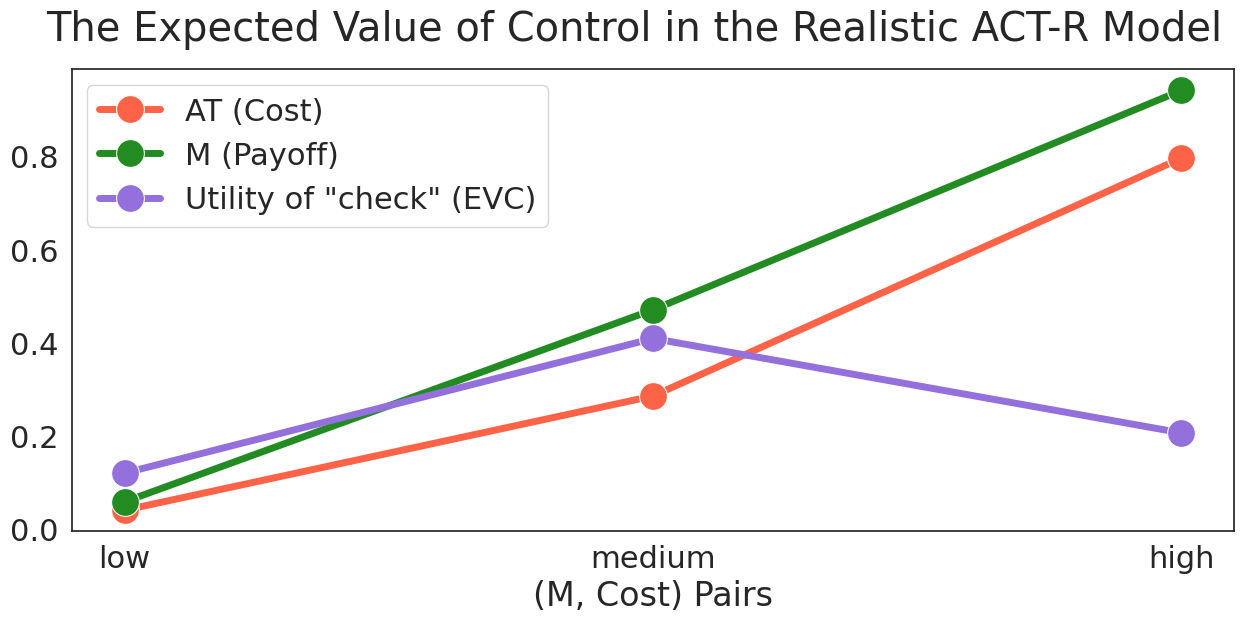

In [7]:
plot_evc(df_model)

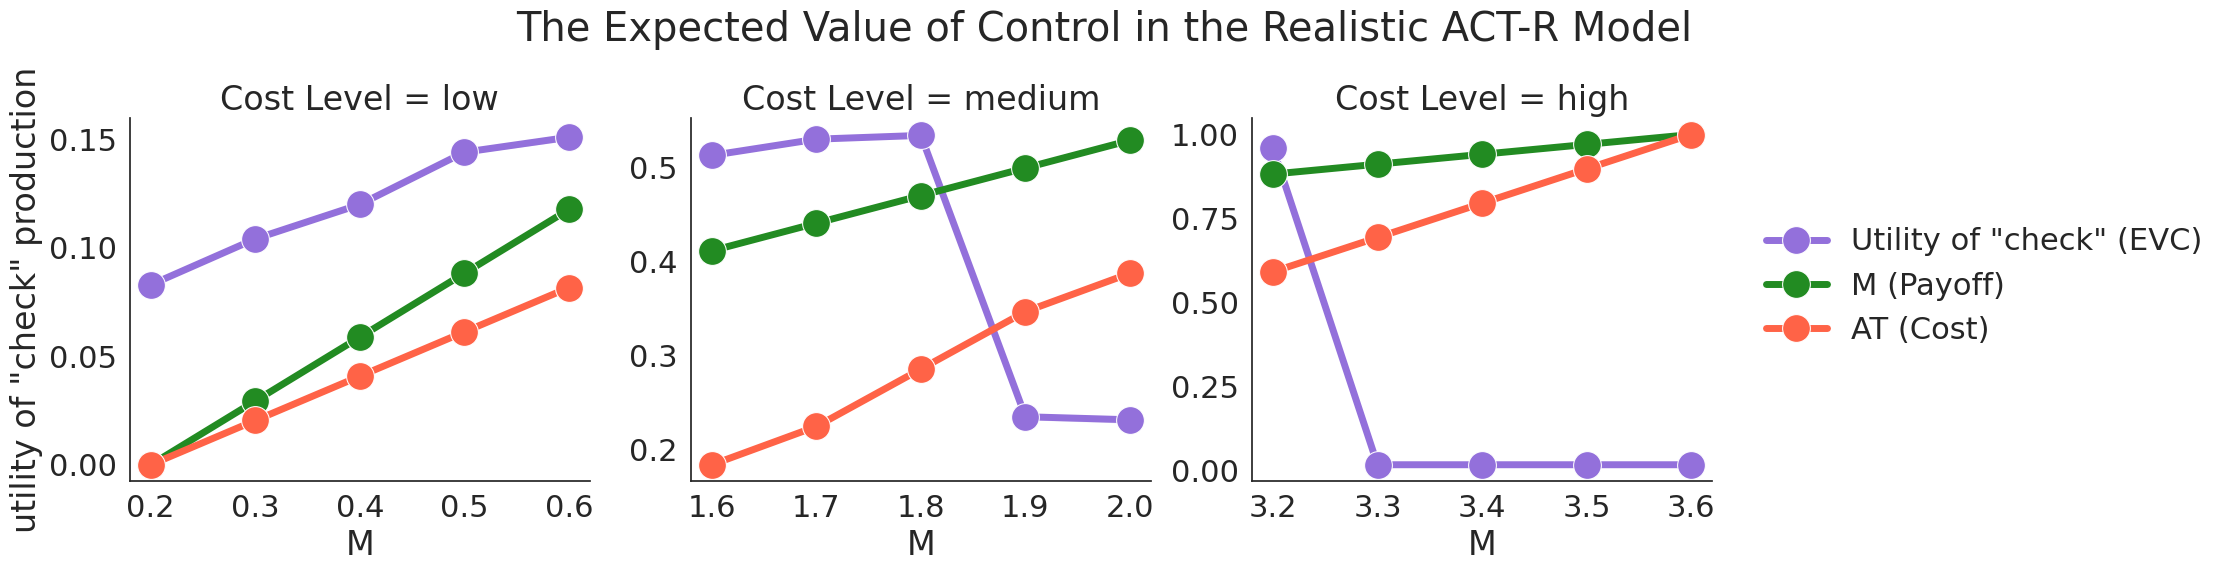

In [13]:
g = sns.FacetGrid(data=df_model, col='cost_level', margin_titles=False, height=6, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x='motivation', y='u_check_norm', markers=True, marker='o', color='mediumpurple', label='Utility of "check" (EVC)', markersize=20)
g.map_dataframe(sns.lineplot, x='motivation', y='motivation_norm', markers=True, marker='o', color='forestgreen',  label='M (Payoff)', markersize=20)
g.map_dataframe(sns.lineplot, x='motivation', y='cost_norm', markers=True, marker='o', color='tomato', label='AT (Cost)', markersize=20)

g.add_legend()
g.set_titles(col_template="Cost Level = {col_name}")
g.tight_layout()
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('The Expected Value of Control in the Realistic ACT-R Model')
g.axes[0,0].set_ylabel('utility of "check" production')
for i in range(3):
    g.axes[0,i].set_xlabel('M')
plt.show()

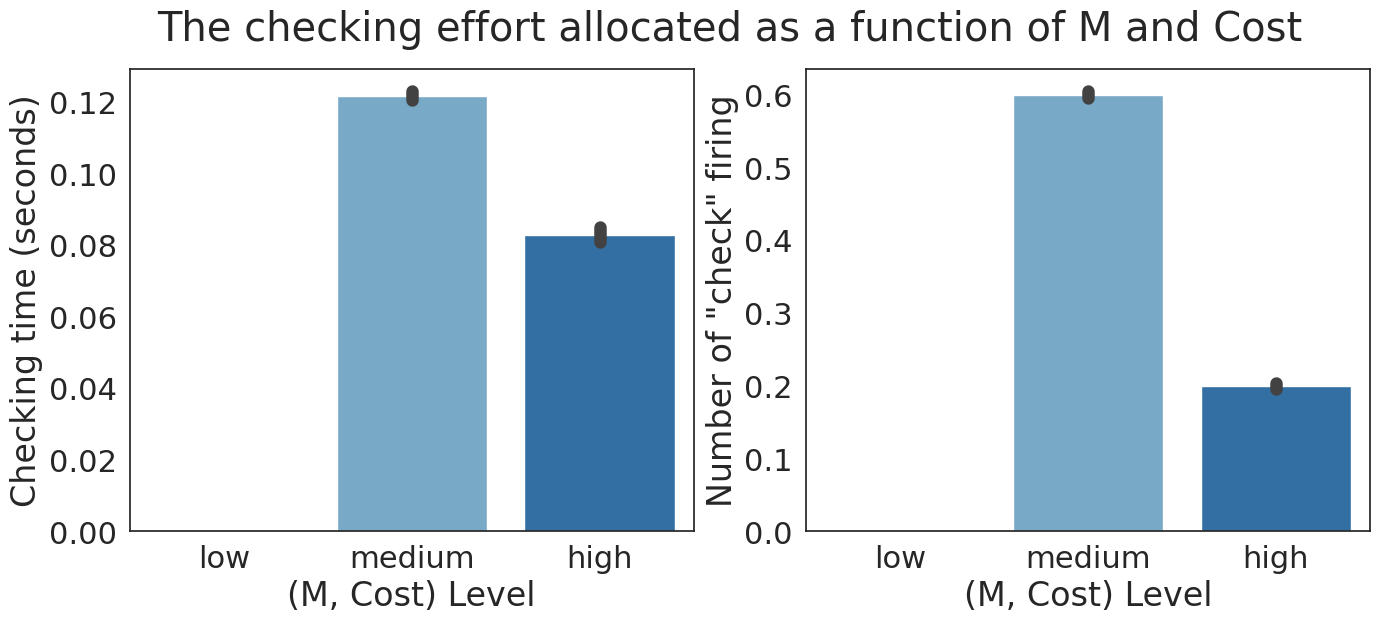

In [9]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('The checking effort allocated as a function of M and Cost')
sns.barplot(data=df_model, x='motivation_cost_level', y='check_time', order=['low', 'medium', 'high'], palette='Blues', ax=axes[0])
sns.barplot(data=df_model, x='motivation_cost_level', y='check_count', order=['low', 'medium', 'high'], palette='Blues', ax=axes[1])

axes[0].set_xlabel('(M, Cost) Level')
axes[1].set_xlabel('(M, Cost) Level')
axes[0].set_ylabel('Checking time (seconds)')
axes[1].set_ylabel('Number of "check" firing')
plt.show()

In [10]:
df_model.groupby(['motivation_cost_level']).agg(check_time_mean=('check_time', 'mean'), 
                                                check_time_sd=('check_time', 'sem'),
                                                check_count_mean=('check_count', 'mean'),
                                                check_count_sd=('check_count', 'sem')).reset_index().round(4)

,motivation_cost_level,check_time_mean,check_time_sd,check_count_mean,check_count_sd
0,low,0.0000,0.0000,0.0,0.0000
1,medium,0.1216,0.0007,0.6,0.0025
2,high,0.0829,0.0010,0.2,0.0021
